In [ ]:
import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras.utils import to_categorical 
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")
# Рисовать графики сразу же
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive #подключаем гугл диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_data = pd.read_csv('/content/drive/My Drive/Базы/traff.csv') #читаем базу
base_data.rename(columns={base_data.columns[0]:'date',base_data.columns[1]:'traffic'}, inplace=True) #переименовываем столбцы

In [ ]:
#Выводим пять первых строк
base_data.head()

,date,traffic
0,1/2/2017,"29,593.00"
1,1/3/2017,"31,726.00"
2,1/4/2017,"32,684.00"
3,1/5/2017,"31,820.00"
4,1/6/2017,"29,354.00"


In [ ]:
base_data.dtypes # проверяем тип данных

date       object
traffic    object
dtype: object

In [ ]:
base_data['traffic'] = base_data['traffic'].astype('<U16') # изменяем тип данных

In [ ]:
def getTraffic(arg): # функция для преобразовывания данных из столбца traffic

  new_arg = arg.replace(',', '') # заменяем запятую на пробел
  
  return float(new_arg) #функция возвращает полученные данные в формате float


In [ ]:
bd = base_data['traffic'].apply(getTraffic) #применяем функцию к столбцу traffic

In [ ]:
bd #проверяем тип данных

0       29593.0
1       31726.0
2       32684.0
3       31820.0
4       29354.0
         ...   
1089    29801.0
1090    34913.0
1091    37665.0
1092    32643.0
1093    28212.0
Name: traffic, Length: 1094, dtype: float64

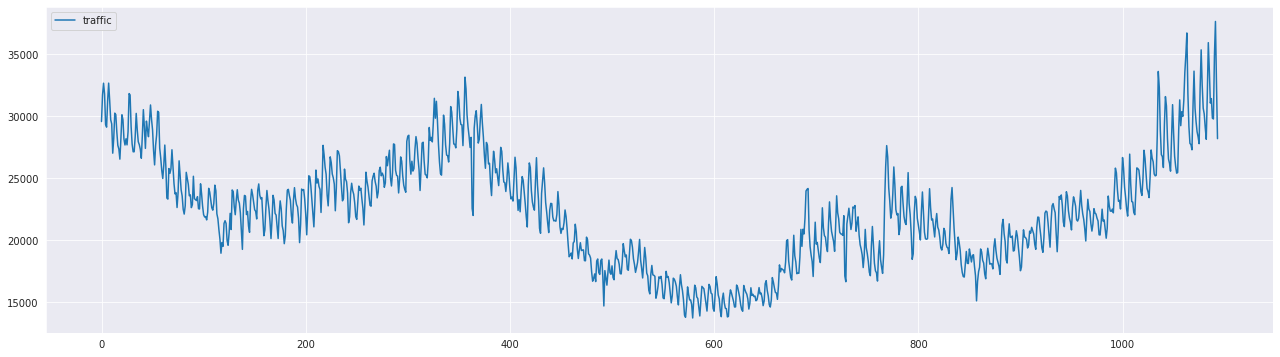

In [ ]:
#отрисовываем исходный сигнал
x=np.arange(1094)
y=bd

plt.figure(figsize=(22,6))
plt.plot(x, y, label="traffic")
plt.legend()
plt.show()


In [ ]:
bd.shape

(1094,)

In [ ]:
xLen = 60                     
valLen = 900          


xTrain, xTest = np.resize(bd[:900], (-1,1)), np.resize(bd[900+xLen+2:], (-1,1)) # Создаем x_train
yTrain, yTest= np.resize(bd[:900], (-1,1)), np.resize(bd[900+xLen+2:], (-1,1)) # Создаем y_train


In [ ]:
yTrain.shape, yTest.shape, xTrain.shape, xTest.shape

((899, 1), (131, 1), (899, 1), (131, 1))

In [ ]:

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=1)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=1)


In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(1, 60, 1) (1, 1)


In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=60, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(60,input_shape = (xLen,1), activation="relu" )) 
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

modelD.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 60, 60)            120       
                                                                 
 flatten_2 (Flatten)         (None, 3600)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 3601      
                                                                 
Total params: 3,721
Trainable params: 3,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=50, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/50
839/839 [==============================] - 47s 56ms/step - loss: 0.0165 - val_loss: 0.0325
Epoch 2/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0071 - val_loss: 0.0219
Epoch 3/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0057 - val_loss: 0.0222
Epoch 4/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0053 - val_loss: 0.0136
Epoch 5/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0048 - val_loss: 0.0101
Epoch 6/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0044 - val_loss: 0.0304
Epoch 7/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0043 - val_loss: 0.0084
Epoch 8/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0039 - val_loss: 0.0076
Epoch 9/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0038 - val_loss: 0.0082
Epoch 10/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0037 - val_loss: 0.00

In [ ]:
#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-5))
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=50, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 2/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 3/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 4/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 5/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 6/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 7/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 8/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0051
Epoch 9/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 10/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0021 - val_loss: 0.0049

In [ ]:
#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-6))
#Запускаем обучение
history = modelD.fit(
                    trainDataGen, 
                    epochs=50, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 2/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 3/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 4/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 5/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 6/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 7/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 8/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 9/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 10/50
839/839 [==============================] - 2s 2ms/step - loss: 0.0020 - val_loss: 0.0044

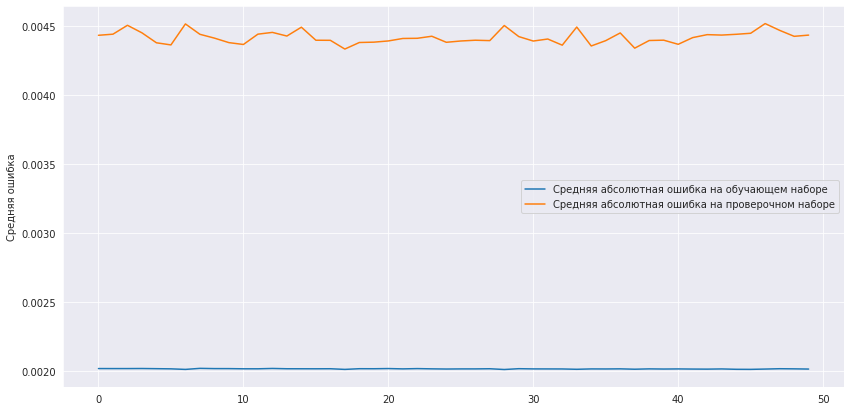

In [ ]:
#Выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

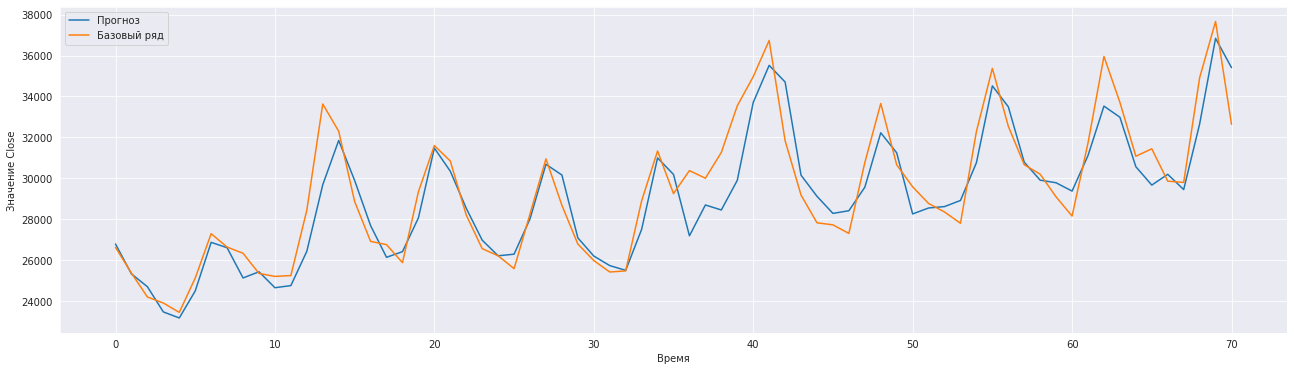

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)

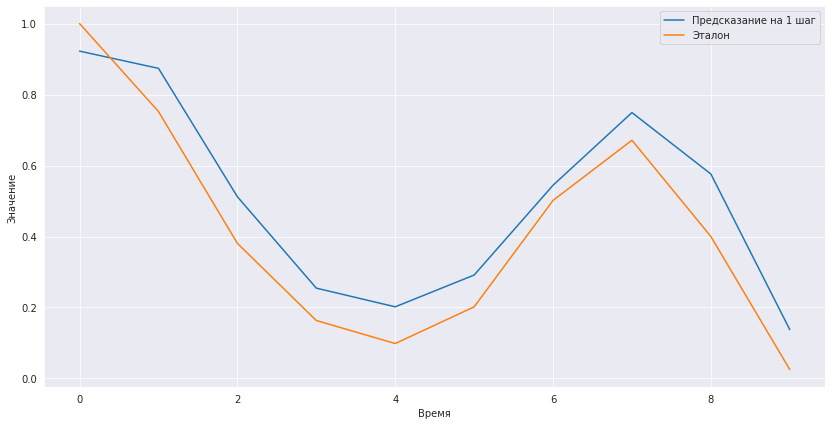

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 10, predVal, yValUnscaled)

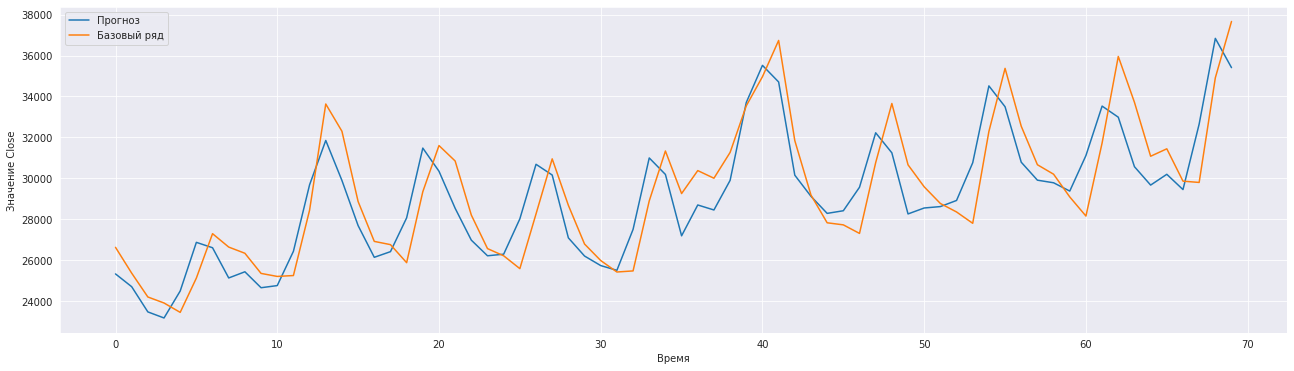

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal[1:], yValUnscaled[:-1])
